# Proper GPs
Much here changed with the help of the `Flux Experimentation.ipynb` notebook. I'll try to make pretty, functional GPs here.

In [1]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

For now we will only consider GPs with zero mean and RBF kernel.

In [2]:
zero_mean() = x -> zeros(size(x))

zero_mean (generic function with 1 method)

In [3]:
rbf(l, σ_f) = 
    (x₁, x₂) -> σ_f.^2 .* exp.(- (x₁ .- x₂').^2 ./ l.^2)

rbf (generic function with 1 method)

Define a new structure `GP` with mean, kernel, and likelihood. It might be better to have a separate likelihood object, but for now this seems handy.

In [4]:
struct GP
    μ
    k
    σ_n
end

In [5]:
gp = GP(zero_mean(), rbf([2.], [0.5]), [0.5])

GP(getfield(Main, Symbol("##3#4"))(), getfield(Main, Symbol("##5#6")){Array{Float64,1},Array{Float64,1}}([2.0], [0.5]), [0.5])

## Prior sample

In [6]:
prior(gp, X) = MultivariateNormal(gp.μ(X), gp.k(X, X) + 1e-6I)

prior (generic function with 1 method)

In [7]:
Xs = 0:0.01:10
prior_distribution = prior(gp, Xs)

FullNormal(
dim: 1001
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.250001 0.249994 … 3.64991e-12 3.47199e-12; 0.249994 0.250001 … 3.83675e-12 3.64991e-12; … ; 3.64991e-12 3.83675e-12 … 0.250001 0.249994; 3.47199e-12 3.64991e-12 … 0.249994 0.250001]
)


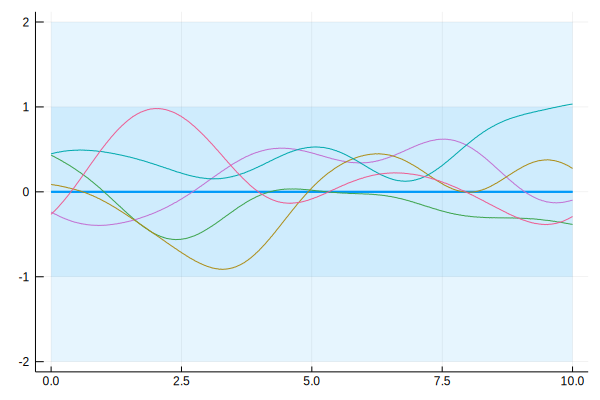

In [8]:
plot(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(prior_distribution.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2(sqrt.(diag(prior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.1, 
    leg=false,
    color=1
)
plot!(Xs, rand(prior_distribution, 5))

## Posterior Sample
First generate some evidence from a single GP sample.

Then condition the GP on this evidence and plot the mean, variance, and some samples from this conditioned GP.

In [9]:
generating_gp = GP(zero_mean(), rbf([0.5], [2]), [0.05])
n = 100
X = 1 .+ rand(n) * 8
generating_dist = prior(generating_gp, Xs)
idx = sample(1:length(Xs), n)
X = Xs[idx]
full_f = rand(generating_dist)
f = full_f[idx]
y = f .+ randn(size(f)) .* generating_gp.σ_n

100-element Array{Float64,1}:
  3.2410657302699697 
 -2.8228675633395937 
  3.7899008489368478 
 -0.8720593536834922 
  2.8388316205986013 
  3.188703104563549  
 -2.536907919878923  
 -2.164095749357881  
 -2.138161294560317  
 -0.05311875693232687
 -0.591890371931277  
 -0.08209936139190839
 -0.8483023449011438 
  ⋮                  
  3.2069646626661132 
  2.8361127929501038 
 -2.099882894171571  
  3.268632983352084  
 -2.196065540120054  
  3.9777138618774837 
  4.702398886398729  
  3.5662307563004916 
 -2.1761171583212997 
 -2.4527904751368528 
  4.807912897524498  
 -0.4677708713588232 

In [10]:
function posterior(gp, X, y, Xs) 
    K = gp.k(X, X)
    Ks = gp.k(X, Xs)
    Kss = gp.k(Xs, Xs)

    K_inv = inv(K + gp.σ_n[1].^2 * I + 1e-6*I)

    cov = Kss - Ks' * K_inv * Ks
    mean = Ks' * K_inv * y
    
    return MultivariateNormal(mean, Symmetric(cov + 1e-6I))
end

posterior (generic function with 1 method)

In [11]:
posterior_distribution = posterior(gp, X, y, Xs)

FullNormal(
dim: 1001
μ: [1.42459, 1.40295, 1.38128, 1.35958, 1.33787, 1.31614, 1.2944, 1.27265, 1.25091, 1.22917  …  -1.68109, -1.67742, -1.67373, -1.67003, -1.66632, -1.66259, -1.65885, -1.6551, -1.65133, -1.64755]
Σ: [0.0359185 0.0356497 … 8.36069e-6 8.30031e-6; 0.0356497 0.0353894 … 8.44012e-6 8.38348e-6; … ; 8.36069e-6 8.44012e-6 … 0.0281929 0.0284278; 8.30031e-6 8.38348e-6 … 0.0284278 0.0286709]
)


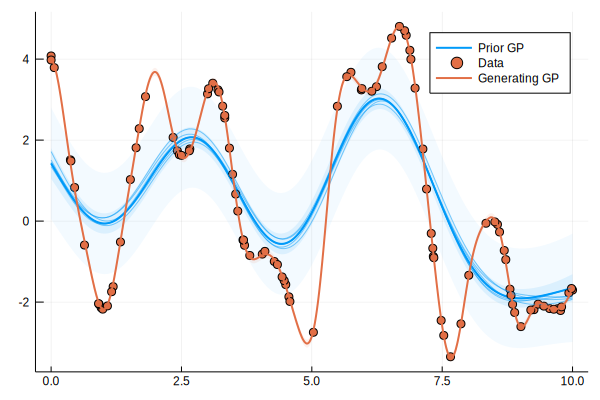

In [12]:
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Prior GP"
)
plot!(
    Xs, posterior_distribution.μ, 
    ribbon=2(sqrt.(diag(posterior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.05, 
    label="",
    color=1
)
scatter!(X, y, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2generating_gp.σ_n, 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)

## Hyperparameter optimization
Now for the fun part: Optimize the GP hyperparameters with Flux and Zygote!

In [13]:
using Flux, Zygote

In [14]:
function mll(gp, X, y)
    data_fit = -1/2 * y' * inv(gp.k(X, X) + gp.σ_n[1]^2 * I + 1e-6I) * y
    model_complexity = -1/2 * logdet(gp.k(X, X)+gp.σ_n[1].^2*I + 1e-6I)
    normalization_term = -length(y)/2 * log(2π)
    @assert length(data_fit) == 1
    @assert length(model_complexity) == 1
    @assert length(normalization_term) == 1
    return data_fit[1] + model_complexity[1] + normalization_term[1]
end
mll(gp, X, y)

-541.1313397488955

In [15]:
prior(gp) = logpdf(Gamma(2, 0.05), gp.k.l[1])
prior(gp)

-33.31538827233207

In [16]:
gp_gs, = gradient(m -> -mll(m, X, y), gp)

((μ = nothing, k = (l = [303.314], σ_f = [-529.571]), σ_n = [-1310.52]),)

ADAM!

In [17]:
η = 0.01
opt = Flux.Optimise.ADAM(η)
println(0, gp.k.l, gp.k.σ_f, gp.σ_n)
for epoch=1:1000
    gp_gs, = gradient(m -> -mll(m, X, y), gp)
    Flux.Tracker.update!(opt, gp.k.l, gp_gs.k.l)
    Flux.Tracker.update!(opt, gp.k.σ_f, gp_gs.k.σ_f)
    Flux.Tracker.update!(opt, gp.σ_n, gp_gs.σ_n)
    if epoch % 100 == 0
        println(epoch, gp.k.l, gp.k.σ_f, gp.σ_n)
    end
end
println("True parameters:", generating_gp.k.l, generating_gp.k.σ_f, generating_gp.σ_n)

0[2.0][0.5][0.5]
100[1.34417][1.0623][0.934849]
200[0.795241][1.32808][0.911603]
300[0.567463][1.52478][0.515356]
400[0.489163][1.68063][0.0414597]
500[0.498617][1.78622][0.0412044]
600[0.502444][1.86805][0.0412631]
700[0.505371][1.93273][0.0413031]
800[0.507635][1.98434][0.0413345]
900[0.509402][2.02564][0.0413594]
1000[0.510785][2.05864][0.041379]
True parameters:[0.5][2][0.05]


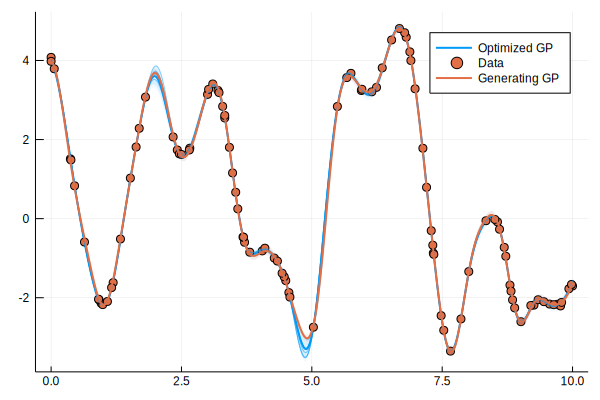

In [18]:
posterior_distribution = posterior(gp, X, y, Xs)
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Optimized GP"
)
plot!(
    Xs, posterior_distribution.μ, 
    ribbon=2(sqrt.(diag(posterior_distribution.Σ)) .+ gp.σ_n), 
    fillalpha=0.05, 
    label="",
    color=1
)

scatter!(X, y, label="Data", color=2)

plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2generating_gp.σ_n, 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)